# Importing required libraries

In [1]:
#Importing necessary libraires for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

#Impoering libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential


import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Dataset

In [2]:
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0

# Pre-processing the data

In [3]:
df = df.drop(['Unnamed: 0','label'],axis=1)

In [4]:
df = df.rename(columns={'label_num':'spam'})

In [5]:
df.head()

text  spam
0  Subject: enron methanol ; meter # : 988291\r\n...     0
1  Subject: hpl nom for january 9 , 2001\r\n( see...     0
2  Subject: neon retreat\r\nho ho ho , we ' re ar...     0
3  Subject: photoshop , windows , office . cheap ...     1
4  Subject: re : indian springs\r\nthis deal is t...     0

In [6]:
df.shape

(5171, 2)

# Visualizing the data

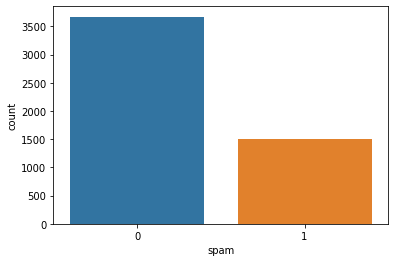

In [7]:
sns.countplot(df['spam'])
plt.show()


Text(0.5, 0, 'Message types')

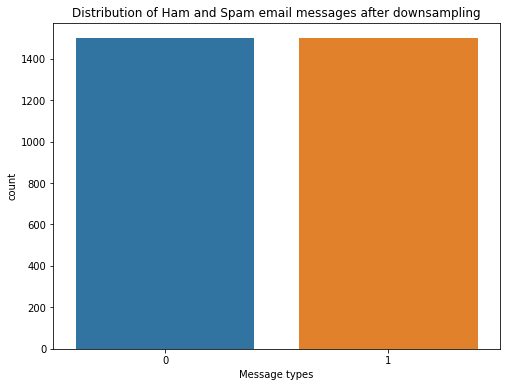

In [8]:
# Downsampling to balance the dataset
ham_msg = df[df.spam == 0]
spam_msg = df[df.spam == 1]
ham_msg = ham_msg.sample(n = len(spam_msg), random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg).reset_index(drop = True)
plt.figure(figsize = (8, 6))
sns.countplot(balanced_data.spam)
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [9]:
df['text'] = df['text'].str.replace('Subject', '')
df.head()


text  spam
0  : enron methanol ; meter # : 988291\r\nthis is...     0
1  : hpl nom for january 9 , 2001\r\n( see attach...     0
2  : neon retreat\r\nho ho ho , we ' re around to...     0
3  : photoshop , windows , office . cheap . main ...     1
4  : re : indian springs\r\nthis deal is to book ...     0

# Removing punctuations from the E-mails

In [10]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['text']= df['text'].apply(lambda x: remove_punctuations(x))
df.head()


text  spam
0   enron methanol  meter   988291\r\nthis is a f...     0
1   hpl nom for january 9  2001\r\n see attached ...     0
2   neon retreat\r\nho ho ho  we  re around to th...     0
3   photoshop  windows  office  cheap  main trend...     1
4   re  indian springs\r\nthis deal is to book th...     0

# Removing stop words

In [11]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['text'] = df['text'].apply(lambda text: remove_stopwords(text))
df.head()


text  spam
0  enron methanol meter 988291 follow note gave m...     0
1  hpl nom january 9 2001 see attached file hplno...     0
2  neon retreat ho ho ho around wonderful time ye...     0
3  photoshop windows office cheap main trending a...     1
4  indian springs deal book teco pvr revenue unde...     0

# Plotting word cloud

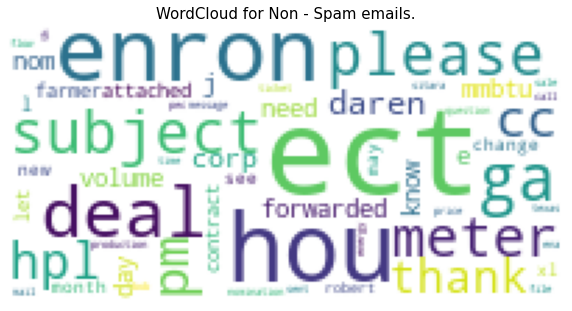

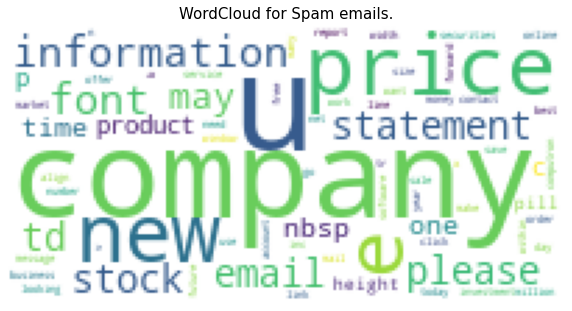

In [12]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(10, 10))
	wc = WordCloud(background_color='white',
				max_words=100,
				width=200,
				height=100,
				collocations=False).generate(email_corpus)

	plt.title(f'WordCloud for {typ} emails.', fontsize=15)
	plt.axis('off')
	plt.imshow(wc)
	plt.show()
	print()


plot_word_cloud(df[df['spam'] == 0], typ='Non - Spam')
plot_word_cloud(df[df['spam'] == 1], typ='Spam')


# Splitting the Dataset in Train and Test

In [13]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


# Converting training and validation data into vectors

In [24]:
# training the tokenizer
token=Tokenizer(num_words = max_words)
token.fit_on_texts(train_X)

#Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
							maxlen = 50,
							padding = 'post',
							truncating = 'post')

Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
							maxlen = 50,
							padding = 'post',
							truncating = 'post')


# Building the Model

In [26]:
# Building the Model
#max_words = 10000
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(max_words, 32, input_length=50),
tf.keras.layers.LSTM(4),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compiling the model

In [27]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


# Defining callback

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


# Fitting the data in model

In [29]:
history = model.fit(Training_pad, train_Y,
                    validation_data = (Testing_pad, test_Y),
                    epochs = 30,
                    verbose = 1,
                    batch_size = 32,
                    callbacks = [lr, es])


Epoch 1/30
75/75 [==============================] - 5s 24ms/step - loss: 0.6693 - accuracy: 0.6889 - val_loss: 0.5935 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 1s 15ms/step - loss: 0.3115 - accuracy: 0.9408 - val_loss: 0.1934 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 1s 16ms/step - loss: 0.1152 - accuracy: 0.9746 - val_loss: 0.1633 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 4/30
75/75 [==============================] - 1s 15ms/step - loss: 0.0636 - accuracy: 0.9875 - val_loss: 0.1259 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/30
75/75 [==============================] - 1s 15ms/step - loss: 0.0641 - accuracy: 0.9871 - val_loss: 0.2033 - val_accuracy: 0.9483 - lr: 0.0010
Epoch 6/30
75/75 [==============================] - 1s 15ms/step - loss: 0.0677 - accuracy: 0.9829 - val_loss: 0.1899 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 7/30
75/75 [==============================] - 1s 15ms/step - loss: 0.0

# Evaluating the model on test data

In [30]:
model.evaluate(Testing_pad, test_Y)


19/19 [==============================] - 0s 3ms/step - loss: 0.1259 - accuracy: 0.9650


[0.12586788833141327, 0.9649999737739563]

# Plotting the model accuracy

Text(0.5, 0, 'epoch')

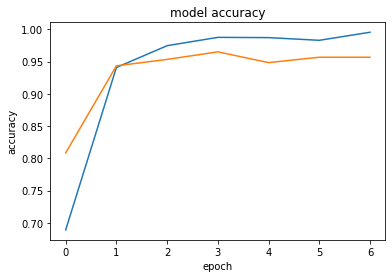

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')


In [36]:
x = 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'
run = token.texts_to_matrix(x)
run1 = pad_sequences(run,
                             maxlen = 50,
                             padding = 'post',
                             truncating = 'post')
model.predict(run1)

5/5 [==============================] - 0s 3ms/step


array([[0.99064654],
       [0.9906539 ],
       [0.99064654],
       [0.99064654],
       [0.9909306 ],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99065375],
       [0.9906667 ],
       [0.99064654],
       [0.99065375],
       [0.99064654],
       [0.99064654],
       [0.99065375],
       [0.99064654],
       [0.99064654],
       [0.9909306 ],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.9909306 ],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.9906667 ],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.9909306 ],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99064654],
       [0.99065375],
       [0.99064654],
       [0.9909306 ],
       [0.99064654],
       [0.990

In [76]:
model.predict(Testing_pad[22].
              reshape(50,1))

2/2 [==============================] - 0s 6ms/step


array([[0.22864103],
       [0.3920388 ],
       [0.35466304],
       [0.5866157 ],
       [0.1531251 ],
       [0.3649859 ],
       [0.41611502],
       [0.36732757],
       [0.14469974],
       [0.1390558 ],
       [0.42801395],
       [0.18005201],
       [0.30066335],
       [0.28475338],
       [0.21312465],
       [0.38837826],
       [0.20562312],
       [0.5866157 ],
       [0.25696108],
       [0.27127102],
       [0.13621096],
       [0.18005201],
       [0.30066335],
       [0.12839957],
       [0.21312465],
       [0.3525747 ],
       [0.14011332],
       [0.34322274],
       [0.41611502],
       [0.36732757],
       [0.14469971],
       [0.13905582],
       [0.1390558 ],
       [0.1916369 ],
       [0.6003153 ],
       [0.29151773],
       [0.14469974],
       [0.1390558 ],
       [0.16941327],
       [0.14502408],
       [0.5866157 ],
       [0.22864103],
       [0.3920388 ],
       [0.25530237],
       [0.43812317],
       [0.1916369 ],
       [0.5866157 ],
       [0.278

In [69]:
Testing_pad[3]

array([  11, 8048,    3,    9, 3355, 2077,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])